In [2]:
import numpy as np
import math
from scipy.signal import convolve2d
import cv2 as cv


class Canny:
    def __init__(self, smooth_ker_size = 5, sigma = 1, t_lower=0, t_upper=0):
        self.smooth_ker_size = smooth_ker_size
        self.sigma = sigma
        self.t_lower = t_lower
        self.t_upper = t_upper
        
        
        
    def get_edges(self, img):
        
        image = img.copy()
        
        
        #1. Noise Reduction
        smooth_image = self.smooth_image(image)
        
        #2. Gradient Calculation
        f_x, f_y = self.calc_gradients(smooth_image)
        f_magnitude = self.gradient_magnitude(f_x, f_y)
        f_orientation = self.gradient_orientation(f_x, f_y)
        
        #3. Non-Max Suppression
        suppressed_image = self.non_max_suppression(f_magnitude, f_orientation)
        
        #4. Double Thresholding
        double_thresholded_image = self.double_thresholding(suppressed_image)
        
        #return suppressed_image
        
        #5. Edge tracking by hysteresis
        
        return double_thresholded_image
        
    def calc_gradients(self, image):
        from scipy.signal import convolve2d

        sobel_x =np.array([[-1, -2, 0, 2, 1],
                           [-2, -3, 0, 3, 2],
                           [-3, -5, 0, 5, 3],
                           [-2, -3, 0, 3, 2],
                           [-1, -2, 0, 2, 1]]) * ( 1 / 20 )

        sobel_y =np.array([[ 1,  2,  3,  2,  1],
                           [ 2,  3,  5,  3,  2],
                           [ 0,  0,  0,  0,  0],
                           [-2, -3, -5, -3, -2],
                           [-1, -2, -3, -2, -1]]) * ( 1 / 20 )

        f_x = convolve2d(image, sobel_x, mode='same', boundary='fill')
        f_y = convolve2d(image, sobel_y, mode='same', boundary='fill')
        
        return f_x, f_y
    
    
    def double_thresholding(self, image):
        M,N = image.shape
        image_double_thresholded = np.copy(image)
        
        if self.t_lower == 0 and self.t_upper == 0:
            mean_magnitude = np.average(image)
            sd_magnitude = np.std(image.ravel())
        
            upper = mean_magnitude + sd_magnitude
            lower = mean_magnitude - sd_magnitude
        else:
            upper = self.t_upper
            lower = self.t_lower
            
            
        
        get_3x3 = lambda image, x, y: image[x-1:x+1, y-1:y+1]
        
        idx_3x3 = np.array([[[-1,-1],[-1, 0],[-1, 1]],
                            [[ 0,-1],[ 0, 0],[ 0, 1]],
                            [[ 1,-1],[ 1, 0],[ 1, 1]]])
        
        
        #set of pixels larger than upper threshold
        max_pixels = list()
        
        #Find initial high values > upper threshold; set to 255
        for x in range(1, M-1):
            for y in range(1, N-1):
                if image[x,y] >= upper:
                    image_double_thresholded[x,y] = 255
                    max_pixels.append([x,y])
                    
                #Set low values < lower threshold to zero
                elif image[x,y] < lower:
                    image_double_thresholded[x,y] = 0
                    
                else:
                    continue

        
        
        while len(max_pixels) > 0:
            #set of newly created max pixels
            max_pixels_new = list()
            
            for i,max_pixel in enumerate(max_pixels):
                x=max_pixel[0]
                y=max_pixel[1]
                
                neighbors = get_3x3(image_double_thresholded, x, y).ravel()
                
                for i,neighbor in enumerate(neighbors):
                    if upper > neighbor > lower:
                        
                        #neighbor list index to neighbor pixel coordinates transformation
                        x_n = idx_3x3[math.floor(i/3),i%3][0] + x
                        y_n = idx_3x3[math.floor(i/3),i%3][1] + y
                        
                        image_double_thresholded[x_n, y_n] = 255
                        
                        max_pixels_new.append([x_n, y_n])
                        
            max_pixels = max_pixels_new
                        
        #Filtering out non-max values
        for x in range(1, M-1):
            for y in range(1, N-1):
                pixel = image_double_thresholded[x, y]
                if pixel < 255:
                    image_double_thresholded[x, y] = 0
                    
                    
        return image_double_thresholded
                    
                
    
    
    
    def non_max_suppression(self, f_magnitude, f_orientation):
        M, N = f_magnitude.shape
        non_max_suppressed = np.zeros((M,N))
    
        #To-do: make sure orientations are within either range -180:180 or -pi:pi
    
    
    #Probably faulty, 0 starts at right side (90 degrees) instead of at 12 oclock  
        #Logic functions
        isVertical = ( lambda orientation: True if ( 
            (90 - math.atan(0.5/1.5) ) < orientation < (90 + math.atan(0.5/1.5) ) or
            (-90 - math.atan(0.5/1.5) ) < orientation < (-90 + math.atan(0.5/1.5) ) 
            ) else False ) 
    
        isHorizontal = ( lambda orientation: True if ( 
            (0 - math.atan(0.5/1.5) ) < orientation < (0 + math.atan(0.5/1.5) ) or
            (180 - math.atan(0.5/1.5) ) < orientation < (-180 + math.atan(0.5/1.5) ) 
            ) else False ) 

        isAntiDiagonal = ( lambda orientation: True if ( 
            (-90 + math.atan(0.5/1.5) ) < orientation < (0 - math.atan(0.5/1.5) ) or
            (90 + math.atan(0.5/1.5) ) < orientation < (180 - math.atan(0.5/1.5) ) 
            ) else False ) 

        isMainDiagonal = ( lambda orientation: True if ( 
            (0 + math.atan(0.5/1.5) ) < orientation < (90 - math.atan(0.5/1.5) ) or
            (-180 - math.atan(0.5/1.5) ) < orientation < (-90 - math.atan(0.5/1.5) ) 
            ) else False ) 
    
        #Finding local maximums in the relevant directions
        for i in range(1, M-1):
            for j in range(1, N-1):
                target_pixel = f_magnitude[i,j]
                orientation = (f_orientation[i,j] )  #* 180 / np.pi
            
                if isHorizontal(orientation):
                    if f_magnitude[i-1,j] <= target_pixel >= f_magnitude[i+1,j]:
                        non_max_suppressed[i,j] = target_pixel
            
                elif isVertical(orientation):
                    if f_magnitude[i,j-1] <= target_pixel >= f_magnitude[i,j+1]:
                        non_max_suppressed[i,j] = target_pixel
                    
                elif isMainDiagonal(orientation):
                    if f_magnitude[i-1,j+1] <= target_pixel >= f_magnitude[i+1,j-1]:
                        non_max_suppressed[i,j] = target_pixel
                
                elif isAntiDiagonal(orientation):
                    if f_magnitude[i-1,j-1] <= target_pixel >= f_magnitude[i+1,j+1]:
                        non_max_suppressed[i,j] = target_pixel
                    
    
        return non_max_suppressed   


        
    def create_gaussian_kernel(self, sigma, k):
        if k % 2 == 0:
            print("Error: k must be an odd integer")
            ker = np.nan
        else:
            ker = np.zeros((k,k))
    
            #c is a constant to adjust array coordinates to kernel coordinates
            c = math.floor(k/2)
    
            for y in range(k):
                for x in range(k):
                    X = x - c
                    Y = y - c
                
                    ker[x,y] = math.exp(-(X**2 + Y**2)/(2*sigma**2))
                
            standardization = self.sum_kernel(ker)
                
            ker = (1/standardization) * ker

        return ker
    
    
    def gradient_magnitude(self, f_x, f_y):
        M,N = f_x.shape
        magnitude = np.zeros((M,N))
    
        for i in range(M):
            for j in range(N):
                magnitude[i,j] = np.sqrt( f_x[i,j]**2 + f_y[i,j]**2 )
        
        return magnitude
        
    
    def gradient_orientation(self, f_x, f_y):
        from math import atan2
        M,N = f_x.shape
        
        orientation = np.zeros((M+self.smooth_ker_size,N))
    
        for i in range(M):
            for j in range(N):
                orientation[i,j] = atan2( f_x[i,j], f_y[i,j] )
            
        return orientation
    
    
    def padding(self, image, ker_width):
        M,N = image.shape
        padding_size = math.ceil(ker_width/2)*2
        padded_image = np.zeros((M+padding_size,N+padding_size))
        
        padded_image[padding_size:M+padding_size, padding_size:N+padding_size] = image
        
        return padded_image
    
    def remove_padding(self, image, ker_width):
        M,N = image.shape
        padding_size = ker_width
        
        return image[padding_size:M-padding_size, padding_size:N-padding_size]
    
    def smooth_image(self, image):
        g_kernel = self.create_gaussian_kernel(sigma=self.sigma, k=self.smooth_ker_size)
        
        #padded_image = self.padding(image, self.smooth_ker_size)
        smooth_img = convolve2d(image, g_kernel, mode='same', boundary='fill')
        #smooth_image = self.remove_padding(smooth_image, self.smooth_ker_size)
        
        return smooth_img
    
    
    def sum_kernel(self, kernel):
        dim = len(kernel[0,:])
    
        sum_ker = 0
        for i in range(dim):
            for j in range(dim):
                sum_ker += kernel[i, j]
    
        return sum_ker
    

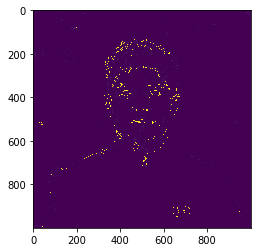

In [7]:
import matplotlib.pyplot as plt
import cv2 as cv
img = cv.imread('images/portret dante.png', 0)

canny = Canny(t_lower=10, t_upper=20)

plt.imshow(canny.get_edges(img))